In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

## Read datasets

In [ ]:
fake = pd.read_csv("data/Fake.csv")
true = pd.read_csv("data/True.csv")

In [ ]:
fake.shape

(23481, 4)

In [ ]:
true.shape

(21417, 4)

## Data cleaning and preparation

In [ ]:
# Add flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

In [ ]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [ ]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [ ]:
# Check the data
data.head()

,title,text,subject,date,target
0,COMRADES IN LIBERAL MI College Town Filled Wit...,University of Michigan is located in Ann Arbor...,politics,"Aug 24, 2016",fake
1,TED CRUZ: Vilification of Law Enforcement Comi...,Ferguson was the a launching pad for Obama s w...,left-news,"Sep 1, 2015",fake
2,OUR CRYBABY COMMUNITY ORGANIZER Makes A Fool O...,,politics,"Nov 17, 2016",fake
3,AWESOME! Conservative Artist Crashes Anti-Trum...,Our favorite conservative street artist Sabo c...,politics,"Nov 13, 2017",fake
4,Senate to vote on Russia sanctions bill later ...,WASHINGTON (Reuters) - The U.S. Senate will vo...,politicsNews,"July 27, 2017",true


In [ ]:
# Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,COMRADES IN LIBERAL MI College Town Filled Wit...,University of Michigan is located in Ann Arbor...,politics,fake
1,TED CRUZ: Vilification of Law Enforcement Comi...,Ferguson was the a launching pad for Obama s w...,left-news,fake
2,OUR CRYBABY COMMUNITY ORGANIZER Makes A Fool O...,,politics,fake
3,AWESOME! Conservative Artist Crashes Anti-Trum...,Our favorite conservative street artist Sabo c...,politics,fake
4,Senate to vote on Russia sanctions bill later ...,WASHINGTON (Reuters) - The U.S. Senate will vo...,politicsNews,true


In [ ]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,University of Michigan is located in Ann Arbor...,politics,fake
1,Ferguson was the a launching pad for Obama s w...,left-news,fake
2,,politics,fake
3,Our favorite conservative street artist Sabo c...,politics,fake
4,WASHINGTON (Reuters) - The U.S. Senate will vo...,politicsNews,true


In [ ]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,university of michigan is located in ann arbor...,politics,fake
1,ferguson was the a launching pad for obama s w...,left-news,fake
2,,politics,fake
3,our favorite conservative street artist sabo c...,politics,fake
4,washington (reuters) - the u.s. senate will vo...,politicsNews,true


In [ ]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [ ]:
# Check
data.head()

,text,subject,target
0,university of michigan is located in ann arbor...,politics,fake
1,ferguson was the a launching pad for obama s w...,left-news,fake
2,,politics,fake
3,our favorite conservative street artist sabo c...,politics,fake
4,washington reuters the us senate will vote on...,politicsNews,true


In [ ]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rohit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data.head()

,text,subject,target
0,university michigan located ann arbor mi home ...,politics,fake
1,ferguson launching pad obama war law enforceme...,left-news,fake
2,,politics,fake
3,favorite conservative street artist sabo crash...,politics,fake
4,washington reuters us senate vote legislation ...,politicsNews,true


## Basic data exploration

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


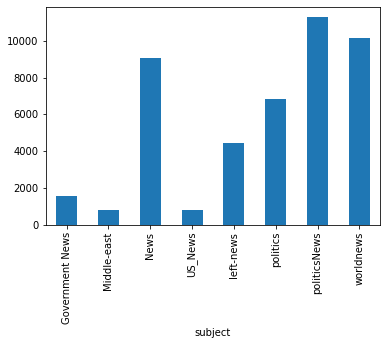

In [ ]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


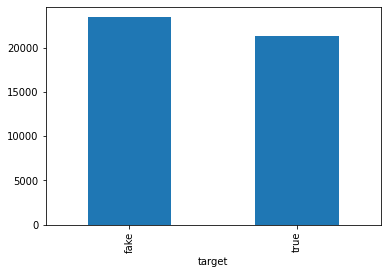

In [ ]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

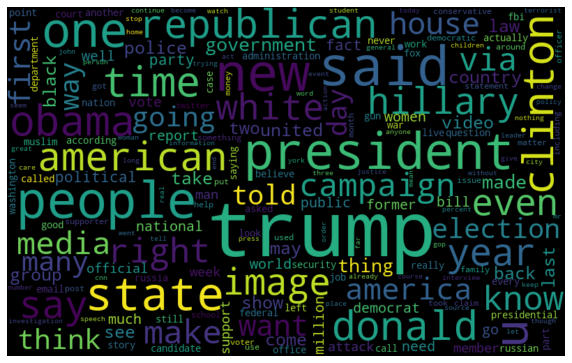

In [ ]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

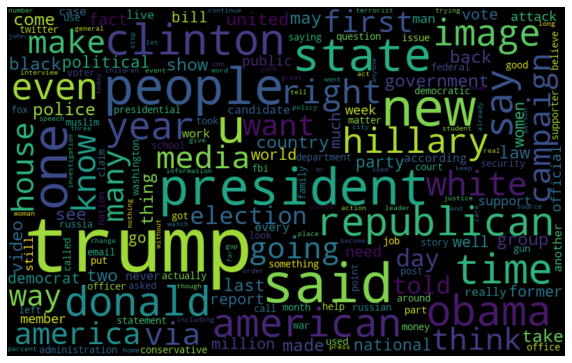

In [ ]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

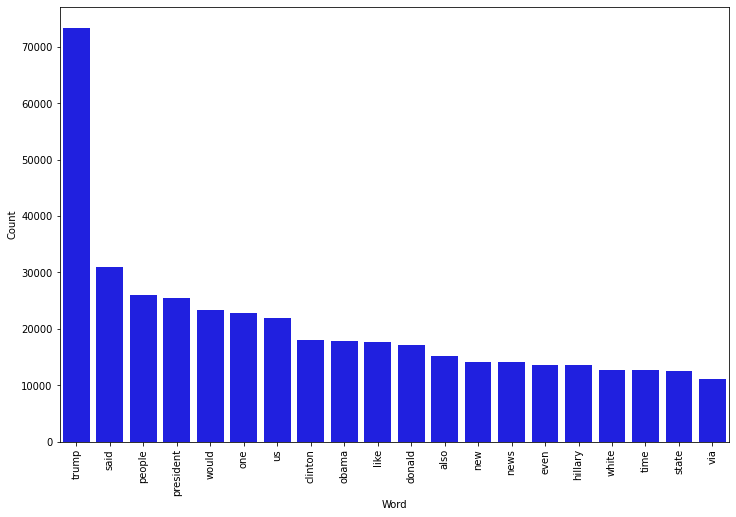

In [ ]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

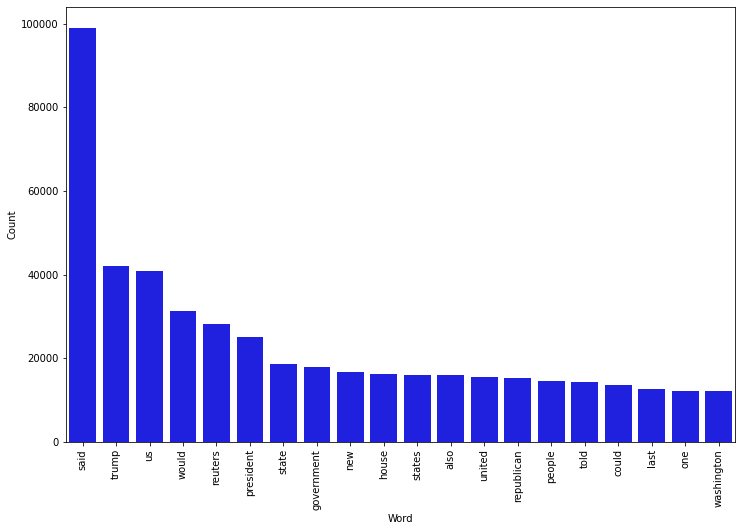

In [ ]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

## Modeling

In [ ]:
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Peparing the data

In [ ]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

# **Naive Bayes**




In [ ]:
dct = dict()

from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', NB_classifier)])

model = pipe.fit(X_train, y_train)

prediction = model.predict(X_test)
dct['Naive Bayes'] = round(accuracy_score(y_test, prediction)*100,2)

print("Accuracy:", round(accuracy_score(y_test, prediction)*100,2))
print("Precision:", round(metrics.precision_score(y_test, prediction, pos_label="true")*100,2))
print("Recall:", round(metrics.recall_score(y_test, prediction, pos_label="true")*100,2))
print("F1 Score:", round(metrics.f1_score(y_test, prediction, pos_label="true")*100,2))

Accuracy: 95.36
Precision: 93.9
Recall: 96.55
F1 Score: 95.2


In [ ]:
print(X_test)

22216    washington reuters activists group supporting ...
27917    justice children without voices spoken detecti...
25007    via tmzolivia wilde posed black white selfie p...
1377     since obama sworn president hundreds thousands...
32476    21st century wire says incredibly day us intel...
                               ...                        
42119    washington reuters head us environmental prote...
4068     season premiere hit television drama empire fe...
22498    community found threats receiving came togethe...
14658    trump invited interesting powerful lineup gues...
15236    buenos aires reuters unusual noise detected la...
Name: text, Length: 8980, dtype: object


Confusion matrix, without normalization


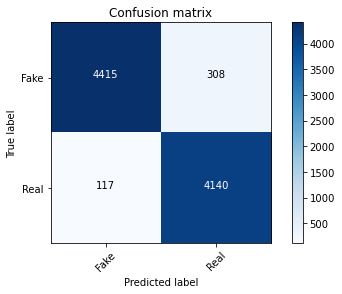

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Logistic regression**

In [ ]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
dct['Logistic Regression'] = round(accuracy_score(y_test, prediction)*100,2)

print("Accuracy:", round(accuracy_score(y_test, prediction)*100,2))
print("Precision:", round(metrics.precision_score(y_test, prediction, pos_label="true")*100,2))
print("Recall:", round(metrics.recall_score(y_test, prediction, pos_label="true")*100,2))
print("F1 Score:", round(metrics.f1_score(y_test, prediction, pos_label="true")*100,2))

Accuracy: 98.81
Precision: 98.51
Recall: 99.0
F1 Score: 98.76


Confusion matrix, without normalization


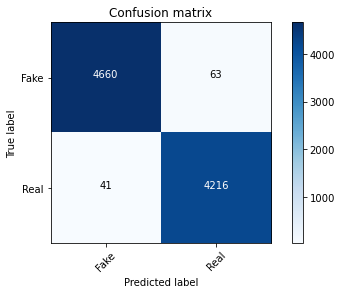

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# model = pipe.fit(["Donald Trump never became the president of United States"], ["false"])

# Accuracy
prediction = model.predict(X_test)
dct['Decision Tree'] = round(accuracy_score(y_test, prediction)*100,2)


print("Accuracy:", round(accuracy_score(y_test, prediction)*100,2))
print("Precision:", round(metrics.precision_score(y_test, prediction, pos_label="true")*100,2))
print("Recall:", round(metrics.recall_score(y_test, prediction, pos_label="true")*100,2))
print("F1 Score:", round(metrics.f1_score(y_test, prediction, pos_label="true")*100,2))

# customX = ["Donald Trump never became the president of United States"]
# customY = ["false"]

# prediction = model.predict(customX)
# print("accuracy: {}%".format(round(accuracy_score(customY, prediction)*100,2)))

Accuracy: 99.7
Precision: 99.7
Recall: 99.67
F1 Score: 99.69


Confusion matrix, without normalization


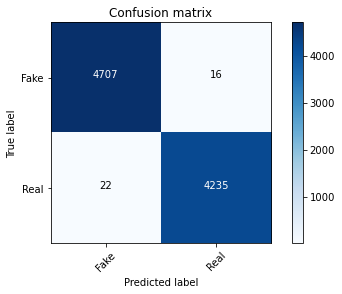

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
dct['Random Forest'] = round(accuracy_score(y_test, prediction)*100,2)

print("Accuracy:", round(accuracy_score(y_test, prediction)*100,2))
print("Precision:", round(metrics.precision_score(y_test, prediction, pos_label="true")*100,2))
print("Recall:", round(metrics.recall_score(y_test, prediction, pos_label="true")*100,2))
print("F1 Score:", round(metrics.f1_score(y_test, prediction, pos_label="true")*100,2))


Accuracy: 98.96
Precision: 98.84
Recall: 99.0
F1 Score: 98.92


Confusion matrix, without normalization


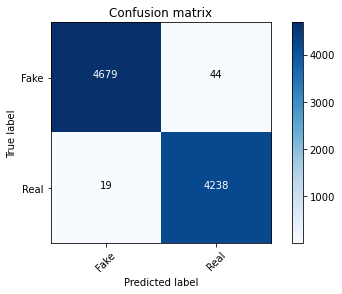

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

## **SVM**

In [ ]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', clf)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)

dct['SVM'] = round(accuracy_score(y_test, prediction)*100,2)

print("Accuracy:", round(accuracy_score(y_test, prediction)*100,2))
print("Precision:", round(metrics.precision_score(y_test, prediction, pos_label="true")*100,2))
print("Recall:", round(metrics.recall_score(y_test, prediction, pos_label="true")*100,2))
print("F1 Score:", round(metrics.f1_score(y_test, prediction, pos_label="true")*100,2))



Accuracy: 99.55
Precision: 99.46
Recall: 99.6
F1 Score: 99.53


Confusion matrix, without normalization


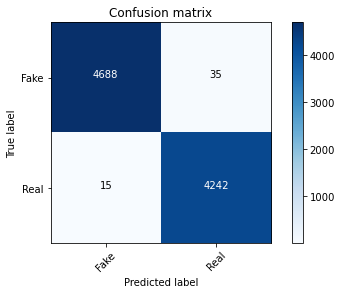

In [ ]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Comparing** **Different Models**

([<matplotlib.axis.YTick at 0x18101096a00>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

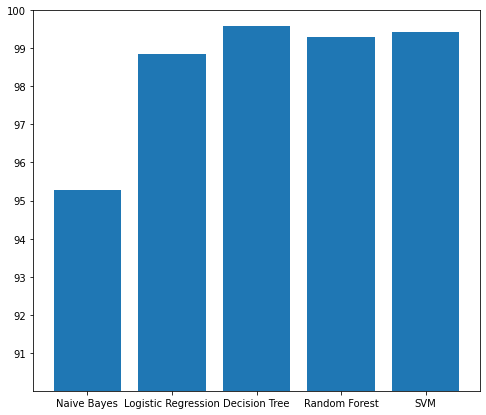

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,7))
plt.bar(list(dct.keys()),list(dct.values()))
plt.ylim(90,100)
plt.yticks((91, 92, 93, 94, 95, 96, 97, 98, 99, 100))

In [ ]:
the end.....